In [1]:
import wave
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plot


In [56]:
FREQ = 1000
THRESHOLD = 128
WPM = 5
NOISE_FACTOR = 0.01
#AUDIO_FILENAME = '/content/Hello Ahmed 5 wpm freq 1000.wav'
#AUDIO_FILENAME = '/content/Hello Ahmed 0 wpm freq 500.wav'
AUDIO_FILENAME = '/content/hello this is sara 10 wpm.wav'
letter_to_morse = {
	"a" : ".-",	"b" : "-...",	"c" : "-.-.",
	"d" : "-..",	"e" : ".",	"f" : "..-.",
	"g" : "--.",	"h" : "....",	"i" : "..",
	"j" : ".---",	"k" : "-.-",	"l" : ".-..",
	"m" : "--",	"n" : "-.",	"o" : "---",
	"p" : ".--.",	"q" : "--.-",	"r" : ".-.",
	"s" : "...",	"t" : "-",	"u" : "..-",
	"v" : "...-",	"w" : ".--",	"x" : "-..-",
	"y" : "-.--",	"z" : "--..",	"1" : ".----",
	"2" : "..---",	"3" : "...--",	"4" : "....-",
	"5" : ".....", 	"6" : "-....",	"7" : "--...",
	"8" : "---..",	"9" : "----.",	"0" : "-----",	
	" " : " "}
morse_to_letters = dict([(value, key) for key, value in letter_to_morse.items()])


In [39]:
def digitize(snd_data):
  sampled = np.asarray(snd_data).copy()
  if sampled[0] == THRESHOLD:
    sampled[0] = 0
  else: sampled[0] = 1
  for i in range(1, len(snd_data)-1):
    if snd_data[i]>THRESHOLD + 4 or snd_data[i]<THRESHOLD-4:
      sampled[i] = 1
    elif snd_data[i-1]<THRESHOLD+4 and snd_data[i-1]>THRESHOLD-4 and snd_data[i+1]<THRESHOLD+4 and snd_data[i+1]>THRESHOLD-4:
      sampled[i] = 0
    else:
      sampled[i] = 1
  sampled[-1] = sampled[-2]
  return np.asarray(sampled)

def preprocess(AUDIO_FILENAME):
  wav_file = wave.open(AUDIO_FILENAME)
  fs, data = wavfile.read(AUDIO_FILENAME)
  data = data
  data = digitize(data) #convert to zeros and ones
  length = data.shape[0] / fs
  time = np.linspace(0., length, data.shape[0])
  plot.plot(data[:3000])
  return time, data

def tone_separator(AUDIO_FILENAME): # returns list of tuples (duration,high/low)
  time, data = preprocess(AUDIO_FILENAME)
  c1 = 0
  c2 = 0
  c3 = 0
  c4 = 0
  tone_sep = []
  rising_edge = 0
  falling_edge = 0
  for i in range(1, len(time)):
    #rising edge 0->1
    if data[i] == 1:
      if data[i-1] == 0:
        c1 = time[i]
        c4 = time[i] #why c4 and c3 ??
        rising_edge = 1
    #falling edge 1->0
    elif data[i] == 0:
      if data[i-1] == 1:
        c2 = time[i]
        c3 = time[i]
        falling_edge = 1
    if c1 != 0 and c2 != 0:
      tone_sep.append((c2-c1, falling_edge))
      rising_edge = 0
      falling_edge = 0
      c1 = 0
      c2 = 0
    if c3 != 0 and c4 != 0 and c4>c3:
      tone_sep.append((c4-c3, falling_edge))
      c3 = 0
      c4 = 0
  tone_sep = filter_tones(tone_sep)
  tone_sep = np.asarray(tone_sep)
  tone_sep = np.round(tone_sep, 2)
  print(tone_sep)
  return tone_sep

def filter_tones(tone_list):
  tone_list = [s for s in tone_list if s[0]>NOISE_FACTOR]
  return tone_list


def normalize_time(tone_list):  ##normaloze the values of the tones, 1  = '.', 2= '-', 3 = letter separation, 4= word separation
  normalized = []
  dot_len= min(tone_list, key = lambda t: t[0]) [0]
  dash_len= dot_len * 3
  word_space = dot_len * 7
  for x in tone_list:
    if x[1] == 1:
      if x[0] == dot_len:
        normalized.append((1, x[1]))
      elif x[0] == dash_len :
        normalized.append((2, x[1]))
    elif x[1]==0:
      if x[0] == word_space:   
        normalized.append((4, x[1]))
      elif x[0] == dash_len:
        normalized.append((3, x[1]))
  normalized.append((3,0.0))
  #print(normalized)
  return normalized

def encode(Tones): #convert the resultant audio into text morse (dots & dashes)
  scentence=[]
  letter = ''
  for tone in Tones:
      if tone[0] == 1 and tone[1] == 1:
        letter+='.'
      elif tone[0] == 2:
        letter += '-'
      elif tone[0] == 3:
        scentence.append(letter)
        letter=''
      elif tone[0] == 4:
        scentence.append(letter)
        scentence.append(' ')
        letter = ''
  return scentence

def decode(morse): #convert the text morse into english letters 
  scentence = ''
  for e in morse:
    scentence += morse_to_letters[e]
  return scentence

def Translate_Morse(AUDIO_FILENAME):
  tones = tone_separator(AUDIO_FILENAME) #correct with all
  get_types(tones)
  tones = normalize_time(tones)
  Morse = encode(tones)
  translation = decode(Morse)
  return translation

[[0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.36 0.  ]
 [0.12 1.  ]
 [0.36 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.36 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.36 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.36 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.36 0.  ]
 [0.36 1.  ]
 [0.12 0.  ]
 [0.36 1.  ]
 [0.12 0.  ]
 [0.36 1.  ]
 [0.84 0.  ]
 [0.36 1.  ]
 [0.36 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.36 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.36 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.84 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.36 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.84 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]
 [0.36 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.36 1.  ]
 [0.36 0.  ]
 [0.12 1.  ]
 [0.12 0.  ]
 [0.36 1.  ]
 [0.12 0.  ]
 [0.12 1.  ]

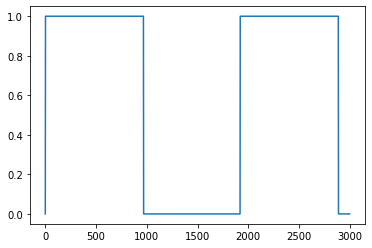

In [57]:
translated = Translate_Morse(AUDIO_FILENAME)
print(translated)

The above cell has the main code the runs all the functions and converts the audio file in 'AUDIO_FILENAME' into english
the morse has to be generated via https://www.meridianoutpost.com/resources/etools/calculators/calculator-morse-code.php?
with the following settings:  
frequency = 1000
WPM = 5
further adjustments may be made to make the translation more generic 

*** 
https://morsecode.world/international/translator.html

In [ ]:
wav_file = wave.open(AUDIO_FILENAME)
fs, data = wavfile.read(AUDIO_FILENAME)
data = data
data=digitize(data)
print(data)
length = data.shape[0] / fs
time = np.linspace(0., length, data.shape[0])
plot.figure(figsize=(20, 7))
plot.plot(time, data, label="Audio Signal")
plot.legend()
plot.xlabel("Time (sec)")
plot.ylabel("Amplitude")
plot.show()


to be general :  we have to get the length of a dot 

1 dash = 3 dots high

space between dots and dashes of the letter = 1 dot low

space between letters = 3 dots low 

space between words = 7 dots low

we can check the smallest length we detected and that would be the length of 1 dot. then, translate high and low dots to dots/dashes or spaces accordingly

In [52]:
import math
import wave
import struct

# Audio will contain a long list of samples (i.e. floating point numbers describing the
# waveform).  If you were working with a very long sound you'd want to stream this to
# disk instead of buffering it all in memory list this.  But most sounds will fit in 
# memory.
audio = []
sample_rate = 44100.0


def append_silence(duration_milliseconds=500):
    """
    Adding silence is easy - we add zeros to the end of our array
    """
    num_samples = duration_milliseconds * (sample_rate / 1000.0)

    for x in range(int(num_samples)): 
        audio.append(0.0)

    return


def append_sinewave(
        freq=440.0, 
        duration_milliseconds=500, 
        volume=1.0):
    """
    The sine wave generated here is the standard beep.  If you want something
    more aggresive you could try a square or saw tooth waveform.   Though there
    are some rather complicated issues with making high quality square and
    sawtooth waves... which we won't address here :) 
    """ 

    global audio # using global variables isn't cool.

    num_samples = duration_milliseconds * (sample_rate / 1000.0)

    for x in range(int(num_samples)):
        audio.append(volume * math.sin(2 * math.pi * freq * ( x / sample_rate )))

    return


def save_wav(file_name):
    # Open up a wav file
    wav_file=wave.open(file_name,"w")

    # wav params
    nchannels = 1

    sampwidth = 2

    # 44100 is the industry standard sample rate - CD quality.  If you need to
    # save on file size you can adjust it downwards. The stanard for low quality
    # is 8000 or 8kHz.
    nframes = len(audio)
    comptype = "NONE"
    compname = "not compressed"
    wav_file.setparams((nchannels, sampwidth, sample_rate, nframes, comptype, compname))

    # WAV files here are using short, 16 bit, signed integers for the 
    # sample size.  So we multiply the floating point data we have by 32767, the
    # maximum value for a short integer.  NOTE: It is theortically possible to
    # use the floating point -1.0 to 1.0 data directly in a WAV file but not
    # obvious how to do that using the wave module in python.
    for sample in audio:
        wav_file.writeframes(struct.pack('h', int( sample * 32767.0 )))

    wav_file.close()

    return


append_sinewave(duration_milliseconds=500, volume=0.25)
append_silence()
append_sinewave(duration_milliseconds=1000, volume=0.5)
append_silence()
append_sinewave()
save_wav("output.wav")

[    0   513  1024 ... -6126 -4097 -2052]


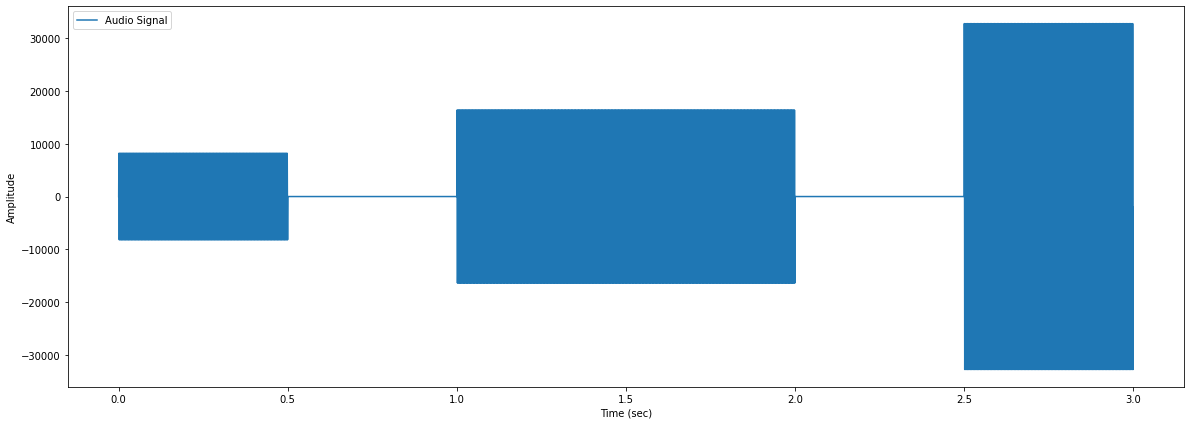

In [53]:
wav_file = wave.open("output.wav")
fs, data = wavfile.read("output.wav")
data = data
#data=digitize(data)
print(data)
length = data.shape[0] / fs
time = np.linspace(0., length, data.shape[0])
plot.figure(figsize=(20, 7))
plot.plot(time, data, label="Audio Signal")
plot.legend()
plot.xlabel("Time (sec)")
plot.ylabel("Amplitude")
plot.show()
